In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
mydir = "/Users/ptienpasertkij/Documents/RIT/Summer 2021/BANA785/All Data Files/"
wegmansData = mydir + "WegmansData_TimeSeries.txt"
wegmans = pd.read_csv(wegmansData, sep=" ")

In [3]:
wegmans

,DATE_KEY,CUSTOMER_ID,ITEM_NBR,UNITS,WEIGHT,SALES,HOUSEHOLD_ID,HOH_AGE,HH_INCOME,HH_CHILDREN,...,month,year,dayofweek,week,monthyear,weekyear,PPU,WEGMANS_ORGANIC,WEGMANS_FAMPACK,IS_BULK
0,2020-02-01,3678,12238,1,0.00,1.86,3678,41,50000.0,2,...,2,2020,7,4,2020/02,2020/04,1.86,0,1,0
1,2020-02-01,3678,50338,1,0.00,3.23,3678,41,50000.0,2,...,2,2020,7,4,2020/02,2020/04,3.23,1,1,0
2,2020-02-01,3678,89921,1,0.65,0.93,3678,41,50000.0,2,...,2,2020,7,4,2020/02,2020/04,0.93,0,0,0
3,2020-02-01,3678,128594,1,0.00,5.03,3678,41,50000.0,2,...,2,2020,7,4,2020/02,2020/04,5.03,0,0,0
4,2019-10-15,855,12213,3,0.00,10.80,855,38,125000.0,0,...,10,2019,3,41,2019/10,2019/41,3.60,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5618230,2020-07-22,644,506594,1,0.65,5.61,644,56,50000.0,3,...,7,2020,4,29,2020/07,2020/29,5.61,0,0,0
5618231,2020-07-22,644,776436,1,0.00,7.19,644,56,50000.0,3,...,7,2020,4,29,2020/07,2020/29,7.19,0,0,0
5618232,2020-07-22,644,798261,1,0.00,4.31,644,56,50000.0,3,...,7,2020,4,29,2020/07,2020/29,4.31,0,0,0
5618233,2020-07-22,644,813430,1,0.00,3.95,644,56,50000.0,3,...,7,2020,4,29,2020/07,2020/29,3.95,0,0,0


In [4]:
wegmans.DATE_KEY = pd.to_datetime(wegmans.DATE_KEY,format='%Y-%m-%d')

In [5]:
wegmans = wegmans.sort_values(['DATE_KEY','DEPARTMENT_NAME','CATEGORY_NAME']) 

In [6]:
wegmansnew = wegmans.groupby([pd.Grouper(key='DATE_KEY',freq='d'),'DEPARTMENT_NAME', 'CATEGORY_NAME'])['SALES'].sum().reset_index()

In [7]:
wegmansnew['Yesterday Sales'] = wegmansnew.groupby(['CATEGORY_NAME'])['SALES'].shift()
wegmansnew['Week Ago Sales'] = wegmansnew.groupby(['CATEGORY_NAME'])['SALES'].shift(7)

In [8]:
wegmansnew['isWeekend'] = (wegmansnew['DATE_KEY'].dt.dayofweek >= 5)

In [9]:
wegmansnew.isna().sum()

DATE_KEY              0
DEPARTMENT_NAME       0
CATEGORY_NAME         0
SALES                 0
Yesterday Sales     581
Week Ago Sales     3996
isWeekend             0
dtype: int64

In [10]:
wegmansnew['Yesterday Sales'].fillna(0, inplace = True)
wegmansnew['Week Ago Sales'].fillna(0, inplace = True)

In [11]:
wegmansnew

,DATE_KEY,DEPARTMENT_NAME,CATEGORY_NAME,SALES,Yesterday Sales,Week Ago Sales,isWeekend
0,2019-01-06,ASIAN,ASIAN HOT,1.43,0.00,0.00,True
1,2019-01-06,ASIAN,ASIAN PACKAGED,91.42,0.00,0.00,True
2,2019-01-06,BAKESHOP,BAGELS,25.26,0.00,0.00,True
3,2019-01-06,BAKESHOP,BAKESHOP COOKIES,39.06,0.00,0.00,True
4,2019-01-06,BAKESHOP,BAKESHOP DISTRIBUTION ITEMS,56.65,0.00,0.00,True
...,...,...,...,...,...,...,...
300640,2020-12-31,SUSHI,SKINNY ROLLS SUSHI,6.47,12.94,11.50,False
300641,2020-12-31,SUSHI,VEGGIE SUSHI,16.52,25.15,25.14,False
300642,2020-12-31,ULTIMATE COFFEE,BREAKFAST,6.46,3.23,3.23,False
300643,2020-12-31,ULTIMATE COFFEE,COLD DRINKS,2.12,1.69,4.60,False


In [12]:
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [13]:
from sklearn.metrics import mean_squared_error
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_error(ytrue, ypred))

In [14]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(wegmansnew['CATEGORY_NAME'])
wegmansnew['CATCODES'] = le.transform(wegmansnew['CATEGORY_NAME'])

In [1]:
import datetime
pd.set_option('mode.chained_assignment',None)

start_date = datetime.date(2019,1,7)
end_date = datetime.date(2020,3,1)
delta = datetime.timedelta(days=1)
windowdelta = datetime.timedelta(days=30)
dateidx = start_date

mean_error = []
wegmanspred = pd.DataFrame() 

while dateidx < end_date:
    print(dateidx)
    train = wegmansnew[(wegmansnew['DATE_KEY'] < pd.Timestamp(dateidx)) & (wegmansnew['DATE_KEY'] > pd.Timestamp(dateidx - windowdelta))]
    val = wegmansnew[wegmansnew['DATE_KEY'] == pd.Timestamp(dateidx)]
    
    if val.size > 0:
        xtr, xts = train[['CATCODES','Yesterday Sales','Week Ago Sales','isWeekend']], val[['CATCODES','Yesterday Sales','Week Ago Sales','isWeekend']]
        ytr, yts = train['SALES'].values, val['SALES'].values
    
        mdl = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=0)
        mdl.fit(xtr, ytr)

        p = mdl.predict(xts)
    
        val.loc[:, 'Prediction'] = np.round(p)
        wegmanspred = pd.concat([wegmanspred,val])
        error = rmsle(yts, p)
        print('Day %s - Error %.5f' % (str(dateidx), error))
        mean_error.append(error)
    dateidx += delta
print('Mean Error = %.5f' % np.mean(mean_error))

NameError: name 'pd' is not defined

In [16]:
wegmanspred.to_csv('prepandemic_30daywindow.csv')

In [17]:
import datetime
pd.set_option('mode.chained_assignment',None)

start_date = datetime.date(2020,3,1)
end_date = datetime.date(2020,12,31)
delta = datetime.timedelta(days=1)
dateidx = start_date

while dateidx <= end_date:
    print(dateidx)
    val = wegmansnew[wegmansnew['DATE_KEY'] == pd.Timestamp(dateidx)] 
    if val.size > 0:
        xts = val[['CATCODES','Yesterday Sales','Week Ago Sales','isWeekend']]
        p = mdl.predict(xts)
        val.loc[:, 'Prediction'] = np.round(p)
        wegmanspred = pd.concat([wegmanspred,val])
    dateidx += delta

2020-03-01
2020-03-02
2020-03-03
2020-03-04
2020-03-05
2020-03-06
2020-03-07
2020-03-08
2020-03-09
2020-03-10
2020-03-11
2020-03-12
2020-03-13
2020-03-14
2020-03-15
2020-03-16
2020-03-17
2020-03-18
2020-03-19
2020-03-20
2020-03-21
2020-03-22
2020-03-23
2020-03-24
2020-03-25
2020-03-26
2020-03-27
2020-03-28
2020-03-29
2020-03-30
2020-03-31
2020-04-01
2020-04-02
2020-04-03
2020-04-04
2020-04-05
2020-04-06
2020-04-07
2020-04-08
2020-04-09
2020-04-10
2020-04-11
2020-04-12
2020-04-13
2020-04-14
2020-04-15
2020-04-16
2020-04-17
2020-04-18
2020-04-19
2020-04-20
2020-04-21
2020-04-22
2020-04-23
2020-04-24
2020-04-25
2020-04-26
2020-04-27
2020-04-28
2020-04-29
2020-04-30
2020-05-01
2020-05-02
2020-05-03
2020-05-04
2020-05-05
2020-05-06
2020-05-07
2020-05-08
2020-05-09
2020-05-10
2020-05-11
2020-05-12
2020-05-13
2020-05-14
2020-05-15
2020-05-16
2020-05-17
2020-05-18
2020-05-19
2020-05-20
2020-05-21
2020-05-22
2020-05-23
2020-05-24
2020-05-25
2020-05-26
2020-05-27
2020-05-28
2020-05-29
2020-05-30

In [18]:
wegmanspred.to_csv('2019and2020predictions_30dayswindow.csv')

In [19]:
import datetime
pd.set_option('mode.chained_assignment',None)

start_date = datetime.date(2019,1,7)
end_date = datetime.date(2020,3,1)
delta = datetime.timedelta(days=1)
windowdelta = datetime.timedelta(days=30)
dateidx = start_date

mean_error_lgbm = []
wegmanspredlgbm = pd.DataFrame() 

while dateidx < end_date:
    print(dateidx)
    train_lgbm = wegmansnew[(wegmansnew['DATE_KEY'] < pd.Timestamp(dateidx)) & (wegmansnew['DATE_KEY'] > pd.Timestamp(dateidx - windowdelta))]
    val_lgbm = wegmansnew[wegmansnew['DATE_KEY'] == pd.Timestamp(dateidx)]
    
    if val_lgbm.size > 0:
        xtr_lgbm, xts_lgbm = train_lgbm[['CATCODES','Yesterday Sales','Week Ago Sales','isWeekend']], val_lgbm[['CATCODES','Yesterday Sales','Week Ago Sales','isWeekend']]
        ytr_lgbm, yts_lgbm = train_lgbm['SALES'].values, val_lgbm['SALES'].values
    
        mdl_lgbm = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
        mdl_lgbm.fit(xtr_lgbm, np.log1p(ytr_lgbm))

        p_lgbm = np.expm1(mdl_lgbm.predict(xts_lgbm))
    
        val_lgbm.loc[:, 'Prediction'] = np.round(p_lgbm)
        wegmanspredlgbm = pd.concat([wegmanspredlgbm,val_lgbm])
        error_lgbm = rmsle(yts_lgbm, p_lgbm)
        print('Day %s - Error %.5f' % (str(dateidx), error_lgbm))
        mean_error_lgbm.append(error_lgbm)
    dateidx += delta
print('Mean Error = %.5f' % np.mean(mean_error_lgbm))

2019-01-07
Day 2019-01-07 - Error 81.73828
2019-01-08
Day 2019-01-08 - Error 96.85362
2019-01-09
Day 2019-01-09 - Error 109.58056
2019-01-10
Day 2019-01-10 - Error 54.01500
2019-01-11
Day 2019-01-11 - Error 66.04314
2019-01-12
Day 2019-01-12 - Error 80.75780
2019-01-13
Day 2019-01-13 - Error 111.87561
2019-01-14
Day 2019-01-14 - Error 38.45213
2019-01-15
Day 2019-01-15 - Error 42.44034
2019-01-16
Day 2019-01-16 - Error 216.75677
2019-01-17
Day 2019-01-17 - Error 98.89386
2019-01-18
Day 2019-01-18 - Error 117.67309
2019-01-19
Day 2019-01-19 - Error 66.82850
2019-01-20
Day 2019-01-20 - Error 104.74740
2019-01-21
Day 2019-01-21 - Error 53.95632
2019-01-22
Day 2019-01-22 - Error 103.98016
2019-01-23
Day 2019-01-23 - Error 75.74016
2019-01-24
Day 2019-01-24 - Error 37.07451
2019-01-25
Day 2019-01-25 - Error 38.88396
2019-01-26
Day 2019-01-26 - Error 130.51491
2019-01-27
Day 2019-01-27 - Error 114.09419
2019-01-28
Day 2019-01-28 - Error 45.67551
2019-01-29
Day 2019-01-29 - Error 39.06186
201

Day 2019-07-16 - Error 22.35699
2019-07-17
Day 2019-07-17 - Error 37.29818
2019-07-18
Day 2019-07-18 - Error 30.33204
2019-07-19
Day 2019-07-19 - Error 30.24017
2019-07-20
Day 2019-07-20 - Error 46.03224
2019-07-21
Day 2019-07-21 - Error 56.29518
2019-07-22
Day 2019-07-22 - Error 43.86206
2019-07-23
Day 2019-07-23 - Error 32.80375
2019-07-24
Day 2019-07-24 - Error 27.88324
2019-07-25
Day 2019-07-25 - Error 76.44637
2019-07-26
Day 2019-07-26 - Error 25.52559
2019-07-27
Day 2019-07-27 - Error 83.14132
2019-07-28
Day 2019-07-28 - Error 36.28165
2019-07-29
Day 2019-07-29 - Error 176.41642
2019-07-30
Day 2019-07-30 - Error 35.51540
2019-07-31
Day 2019-07-31 - Error 480.44821
2019-08-01
Day 2019-08-01 - Error 46.67527
2019-08-02
Day 2019-08-02 - Error 43.82592
2019-08-03
Day 2019-08-03 - Error 32.43759
2019-08-04
Day 2019-08-04 - Error 38.75395
2019-08-05
Day 2019-08-05 - Error 44.86037
2019-08-06
Day 2019-08-06 - Error 40.49819
2019-08-07
Day 2019-08-07 - Error 29.05930
2019-08-08
Day 2019-

Day 2020-01-24 - Error 40.88900
2020-01-25
Day 2020-01-25 - Error 33.37037
2020-01-26
Day 2020-01-26 - Error 47.75550
2020-01-27
Day 2020-01-27 - Error 38.99989
2020-01-28
Day 2020-01-28 - Error 149.92373
2020-01-29
Day 2020-01-29 - Error 21.58871
2020-01-30
Day 2020-01-30 - Error 30.25688
2020-01-31
Day 2020-01-31 - Error 41.97258
2020-02-01
Day 2020-02-01 - Error 59.23596
2020-02-02
Day 2020-02-02 - Error 46.44698
2020-02-03
Day 2020-02-03 - Error 50.46743
2020-02-04
Day 2020-02-04 - Error 28.38728
2020-02-05
Day 2020-02-05 - Error 49.36721
2020-02-06
Day 2020-02-06 - Error 23.15304
2020-02-07
Day 2020-02-07 - Error 35.68815
2020-02-08
Day 2020-02-08 - Error 42.96110
2020-02-09
Day 2020-02-09 - Error 43.91451
2020-02-10
Day 2020-02-10 - Error 27.96251
2020-02-11
Day 2020-02-11 - Error 27.37713
2020-02-12
Day 2020-02-12 - Error 51.00186
2020-02-13
Day 2020-02-13 - Error 55.65671
2020-02-14
Day 2020-02-14 - Error 63.94621
2020-02-15
Day 2020-02-15 - Error 97.20333
2020-02-16
Day 2020-0

In [20]:
import datetime
pd.set_option('mode.chained_assignment',None)

start_date = datetime.date(2020,3,1)
end_date = datetime.date(2020,12,31)
delta = datetime.timedelta(days=1)
dateidx = start_date

while dateidx <= end_date:
    print(dateidx)
    val_lgbm = wegmansnew[wegmansnew['DATE_KEY'] == pd.Timestamp(dateidx)] 
    if val_lgbm.size > 0:
        xts_lgbm = val_lgbm[['CATCODES','Yesterday Sales','Week Ago Sales','isWeekend']]
        p_lgbm = mdl_lgbm.predict(xts_lgbm)
        val_lgbm.loc[:, 'Prediction'] = np.round(p_lgbm)
        wegmanspredlgbm = pd.concat([wegmanspredlgbm,val_lgbm])
    dateidx += delta

2020-03-01
2020-03-02
2020-03-03
2020-03-04
2020-03-05
2020-03-06
2020-03-07
2020-03-08
2020-03-09
2020-03-10
2020-03-11
2020-03-12
2020-03-13
2020-03-14
2020-03-15
2020-03-16
2020-03-17
2020-03-18
2020-03-19
2020-03-20
2020-03-21
2020-03-22
2020-03-23
2020-03-24
2020-03-25
2020-03-26
2020-03-27
2020-03-28
2020-03-29
2020-03-30
2020-03-31
2020-04-01
2020-04-02
2020-04-03
2020-04-04
2020-04-05
2020-04-06
2020-04-07
2020-04-08
2020-04-09
2020-04-10
2020-04-11
2020-04-12
2020-04-13
2020-04-14
2020-04-15
2020-04-16
2020-04-17
2020-04-18
2020-04-19
2020-04-20
2020-04-21
2020-04-22
2020-04-23
2020-04-24
2020-04-25
2020-04-26
2020-04-27
2020-04-28
2020-04-29
2020-04-30
2020-05-01
2020-05-02
2020-05-03
2020-05-04
2020-05-05
2020-05-06
2020-05-07
2020-05-08
2020-05-09
2020-05-10
2020-05-11
2020-05-12
2020-05-13
2020-05-14
2020-05-15
2020-05-16
2020-05-17
2020-05-18
2020-05-19
2020-05-20
2020-05-21
2020-05-22
2020-05-23
2020-05-24
2020-05-25
2020-05-26
2020-05-27
2020-05-28
2020-05-29
2020-05-30

In [21]:
wegmanspredlgbm.to_csv('2019and2020pred_30daywindow_lbgbm.csv')

### Analysis Begins

In [22]:
wegmans_pre = wegmans[(wegmans['DATE_KEY'] >= '2019-01-06') & (wegmans['DATE_KEY'] <= '2020-02-29')]

In [23]:
wegmans_during = wegmans[(wegmans['DATE_KEY'] > '2020-02-29') & (wegmans['DATE_KEY'] <= '2020-12-31')]

In [24]:
wegmans_lgbmpre = wegmanspredlgbm[(wegmanspredlgbm['DATE_KEY'] >= '2019-01-06') & (wegmanspredlgbm['DATE_KEY'] <= '2020-02-29')]

In [25]:
wegmans_lgbmduring = wegmanspredlgbm[(wegmanspredlgbm['DATE_KEY'] >= '2019-01-06') & (wegmanspredlgbm['DATE_KEY'] <= '2020-02-29')]

In [26]:
wegmansnew_pre = wegmansnew[(wegmansnew['DATE_KEY'] >= '2019-01-06') & (wegmansnew['DATE_KEY'] <= '2020-02-29')]

In [27]:
wegmansnew_during = wegmansnew[(wegmansnew['DATE_KEY'] > '2020-02-29') & (wegmansnew['DATE_KEY'] <= '2020-12-31')]

In [28]:
wegmans

,DATE_KEY,CUSTOMER_ID,ITEM_NBR,UNITS,WEIGHT,SALES,HOUSEHOLD_ID,HOH_AGE,HH_INCOME,HH_CHILDREN,...,month,year,dayofweek,week,monthyear,weekyear,PPU,WEGMANS_ORGANIC,WEGMANS_FAMPACK,IS_BULK
2998247,2019-01-06,5289,222267,1,0.0,1.43,445,39,125000.0,1,...,1,2019,1,1,2019/01,2019/01,1.43,0,0,0
309961,2019-01-06,4907,154472,1,0.0,2.51,774,50,75000.0,0,...,1,2019,1,1,2019/01,2019/01,2.51,0,0,0
309972,2019-01-06,4907,556328,1,0.0,5.04,774,50,75000.0,0,...,1,2019,1,1,2019/01,2019/01,5.04,0,0,0
629001,2019-01-06,3530,135451,1,0.0,5.76,3530,63,100000.0,1,...,1,2019,1,1,2019/01,2019/01,5.76,0,0,0
923481,2019-01-06,2295,556328,1,0.0,5.04,2295,30,40000.0,0,...,1,2019,1,1,2019/01,2019/01,5.04,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2689097,2020-12-31,1997,48147,1,0.0,6.47,1997,60,100000.0,0,...,12,2020,5,52,2020/12,2020/52,6.47,0,0,0
3919347,2020-12-31,1897,39305,1,0.0,8.63,1897,73,100000.0,1,...,12,2020,5,52,2020/12,2020/52,8.63,0,0,0
4909291,2020-12-31,2487,39292,1,0.0,8.63,2487,60,125000.0,2,...,12,2020,5,52,2020/12,2020/52,8.63,0,0,0
5016221,2020-12-31,5584,39290,1,0.0,8.63,2706,81,75000.0,0,...,12,2020,5,52,2020/12,2020/52,8.63,0,0,0


In [29]:
wegmansnew

,DATE_KEY,DEPARTMENT_NAME,CATEGORY_NAME,SALES,Yesterday Sales,Week Ago Sales,isWeekend,CATCODES
0,2019-01-06,ASIAN,ASIAN HOT,1.43,0.00,0.00,True,14
1,2019-01-06,ASIAN,ASIAN PACKAGED,91.42,0.00,0.00,True,15
2,2019-01-06,BAKESHOP,BAGELS,25.26,0.00,0.00,True,23
3,2019-01-06,BAKESHOP,BAKESHOP COOKIES,39.06,0.00,0.00,True,26
4,2019-01-06,BAKESHOP,BAKESHOP DISTRIBUTION ITEMS,56.65,0.00,0.00,True,27
...,...,...,...,...,...,...,...,...
300640,2020-12-31,SUSHI,SKINNY ROLLS SUSHI,6.47,12.94,11.50,False,488
300641,2020-12-31,SUSHI,VEGGIE SUSHI,16.52,25.15,25.14,False,557
300642,2020-12-31,ULTIMATE COFFEE,BREAKFAST,6.46,3.23,3.23,False,52
300643,2020-12-31,ULTIMATE COFFEE,COLD DRINKS,2.12,1.69,4.60,False,112


In [30]:
wegmanspredlgbm

,DATE_KEY,DEPARTMENT_NAME,CATEGORY_NAME,SALES,Yesterday Sales,Week Ago Sales,isWeekend,CATCODES,Prediction
439,2019-01-07,ASIAN,ASIAN HOT,1.43,1.43,0.00,False,14,37.0
440,2019-01-07,ASIAN,ASIAN PACKAGED,41.76,91.42,0.00,False,15,37.0
441,2019-01-07,BAKESHOP,BAGELS,12.70,117.27,0.00,False,23,37.0
442,2019-01-07,BAKESHOP,BAKESHOP COOKIES,35.63,39.06,0.00,False,26,28.0
443,2019-01-07,BAKESHOP,BAKESHOP DISTRIBUTION ITEMS,19.35,56.65,0.00,False,27,28.0
...,...,...,...,...,...,...,...,...,...
300640,2020-12-31,SUSHI,SKINNY ROLLS SUSHI,6.47,12.94,11.50,False,488,2.0
300641,2020-12-31,SUSHI,VEGGIE SUSHI,16.52,25.15,25.14,False,557,3.0
300642,2020-12-31,ULTIMATE COFFEE,BREAKFAST,6.46,3.23,3.23,False,52,2.0
300643,2020-12-31,ULTIMATE COFFEE,COLD DRINKS,2.12,1.69,4.60,False,112,2.0


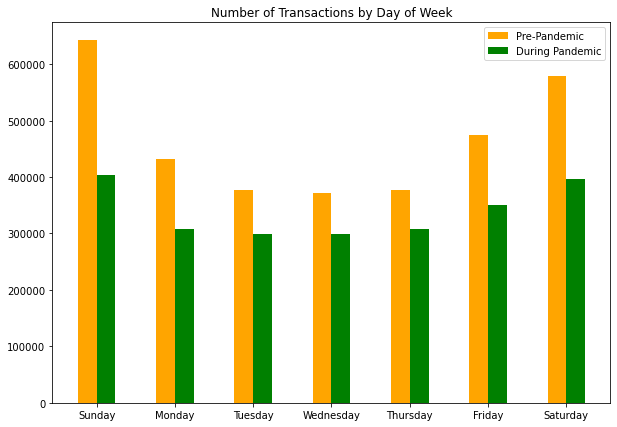

In [31]:
x_wegmansdaypre = wegmans_pre['dayofweek'].value_counts(sort=False).index
y_wegmansdaypre = wegmans_pre['dayofweek'].value_counts(sort=False).values

x_wegmansdayduring = wegmans_during['dayofweek'].value_counts(sort=False).index
y_wegmansdayduring = wegmans_during['dayofweek'].value_counts(sort=False).values

fig = plt.figure(figsize = (10, 7))

width = 0.24

plt.bar(x_wegmansdaypre-.12, y_wegmansdaypre, width, color="orange")
plt.bar(x_wegmansdayduring+0.12, y_wegmansdayduring, width, color="green")

plt.xticks(x_wegmansdaypre,['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])
plt.title("Number of Transactions by Day of Week")
plt.legend(["Pre-Pandemic", "During Pandemic"])
plt.show()

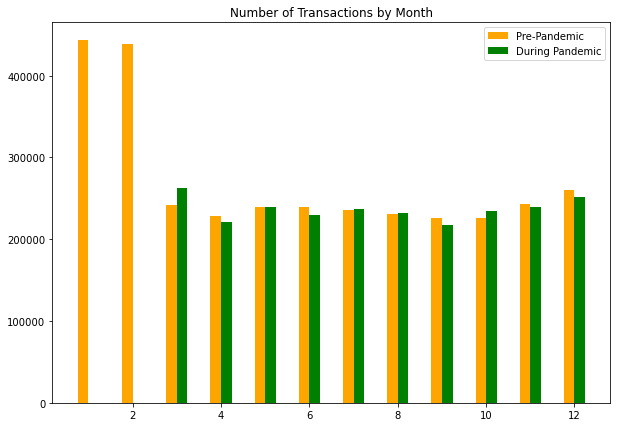

In [32]:
x_wegmansmonthpre = wegmans_pre['month'].value_counts(sort=False).index
y_wegmansmonthpre = wegmans_pre['month'].value_counts(sort=False).values

x_wegmansmonthduring = wegmans_during['month'].value_counts(sort=False).index
y_wegmansmonthduring = wegmans_during['month'].value_counts(sort=False).values

fig = plt.figure(figsize = (10, 7))

width = 0.24

plt.bar(x_wegmansmonthpre-.12, y_wegmansmonthpre, width, color="orange")
plt.bar(x_wegmansmonthduring+0.12, y_wegmansmonthduring, width, color="green")

plt.title("Number of Transactions by Month")
plt.legend(["Pre-Pandemic", "During Pandemic"])
plt.show()

In [33]:
topsalespre_dept = wegmansnew_pre.groupby(['DEPARTMENT_NAME'], as_index=False).agg({"SALES": "sum"}).sort_values(('SALES'), ascending=False)

In [34]:
topsalesduring_dept = wegmansnew_during.groupby(['DEPARTMENT_NAME'], as_index=False).agg({"SALES": "sum"}).sort_values(('SALES'), ascending=False)

In [35]:
topsales_dept = pd.merge(topsalespre_dept, topsalesduring_dept, on='DEPARTMENT_NAME')

In [36]:
topsalespre_dept.head(8)

,DEPARTMENT_NAME,SALES
22,GROCERY,2890225.75
36,PRODUCE,1251625.10
30,MEAT,812680.40
10,DAIRY,665352.00
23,HEALTH & BEAUTY CARE,602118.37
34,PHARMACY RX,517348.55
16,FROZEN FOOD,406568.92
6,COLD CUTS & CHEESE,221297.74


In [37]:
topsalesduring_dept.head(8)

,DEPARTMENT_NAME,SALES
22,GROCERY,2247591.80
36,PRODUCE,941185.24
30,MEAT,684533.04
10,DAIRY,533869.47
23,HEALTH & BEAUTY CARE,439490.84
16,FROZEN FOOD,344286.58
2,BEER & WINE COOLERS,205471.53
6,COLD CUTS & CHEESE,181052.19


In [38]:
topsales_dept = topsales_dept[(topsales_dept["DEPARTMENT_NAME"] == 'GROCERY') |
             (topsales_dept["DEPARTMENT_NAME"] == 'PRODUCE') |
             (topsales_dept["DEPARTMENT_NAME"] == 'MEAT') |
             (topsales_dept["DEPARTMENT_NAME"] == 'DAIRY') |
             (topsales_dept["DEPARTMENT_NAME"] == 'HEALTH & BEAUTY CARE') |
             (topsales_dept["DEPARTMENT_NAME"] == 'PHARMACY RX') |
             (topsales_dept["DEPARTMENT_NAME"] == 'FROZEN FOOD') |
             (topsales_dept["DEPARTMENT_NAME"] == 'COLD CUT & CHEESE') |
             (topsales_dept["DEPARTMENT_NAME"] == 'BEER & WINE COOLERS')]

In [39]:
topsales_dept.head(8)

,DEPARTMENT_NAME,SALES_x,SALES_y
0,GROCERY,2890225.75,2247591.80
1,PRODUCE,1251625.10,941185.24
2,MEAT,812680.40,684533.04
3,DAIRY,665352.00,533869.47
4,HEALTH & BEAUTY CARE,602118.37,439490.84
5,PHARMACY RX,517348.55,119924.56
6,FROZEN FOOD,406568.92,344286.58
8,BEER & WINE COOLERS,219486.24,205471.53


In [40]:
topchangepre_dept = wegmansnew_pre.groupby(['DEPARTMENT_NAME'], as_index=False).agg({"SALES": "sum"})

In [41]:
topchangeduring_dept = wegmansnew_during.groupby(['DEPARTMENT_NAME'], as_index=False).agg({"SALES": "sum"})

In [42]:
topchange_dept = pd.merge(topchangepre_dept, topchangeduring_dept, on='DEPARTMENT_NAME')

In [43]:
topchange_dept['CHANGE_IN_SALES'] = ((topchange_dept['SALES_y']-topchange_dept['SALES_x'])/topchange_dept['SALES_x'])

In [44]:
topchange_dept.sort_values(('CHANGE_IN_SALES'), ascending=False)

,DEPARTMENT_NAME,SALES_x,SALES_y,CHANGE_IN_SALES
40,SPECIAL PROMOTIONS,0.00,21.60,inf
12,DIGITAL FULFILLMENT,256.35,664.75,1.593134
18,FROZEN SEAFOOD,68782.33,65449.73,-0.048451
2,BEER & WINE COOLERS,219486.24,205471.53,-0.063852
15,FRESH SEAFOOD,116746.09,108120.27,-0.073885
17,FROZEN MEAT,34378.96,30717.29,-0.106509
11,DAIRY PRE-PACK,95944.18,82877.33,-0.136192
25,ICE CREAM,132076.15,113525.01,-0.140458
16,FROZEN FOOD,406568.92,344286.58,-0.153190
30,MEAT,812680.40,684533.04,-0.157685


In [45]:
topchange_dept = topchange_dept[(topchange_dept["DEPARTMENT_NAME"] == 'DIGITAL FULFILLMENT') |
             (topchange_dept["DEPARTMENT_NAME"] == 'PHARMACY RX') |
             (topchange_dept["DEPARTMENT_NAME"] == 'WBRAND & OTHER') |
             (topchange_dept["DEPARTMENT_NAME"] == 'RESTAURANTS') |
             (topchange_dept["DEPARTMENT_NAME"] == 'PHARMACY OTC') |
             (topchange_dept["DEPARTMENT_NAME"] == 'ULTIMATE COFFEE') |
             (topchange_dept["DEPARTMENT_NAME"] == 'COSMETICS') |
             (topchange_dept["DEPARTMENT_NAME"] == 'GROCERY') |
             (topchange_dept["DEPARTMENT_NAME"] == 'PRODUCE') |
            (topchange_dept["DEPARTMENT_NAME"] == 'HEALTH & BEAUTY CARE') ]

In [46]:
topchange_dept.sort_values(('CHANGE_IN_SALES'),ascending=False)

,DEPARTMENT_NAME,SALES_x,SALES_y,CHANGE_IN_SALES
12,DIGITAL FULFILLMENT,256.35,664.75,1.593134
22,GROCERY,2890225.75,2247591.80,-0.222347
36,PRODUCE,1251625.10,941185.24,-0.248029
23,HEALTH & BEAUTY CARE,602118.37,439490.84,-0.270092
8,COSMETICS,33545.48,16561.65,-0.506293
42,ULTIMATE COFFEE,7826.40,3548.40,-0.546611
33,PHARMACY OTC,514.10,209.05,-0.593367
38,RESTAURANTS,5917.50,1765.58,-0.701634
43,WBRAND & OTHER,87119.84,24570.84,-0.717965
34,PHARMACY RX,517348.55,119924.56,-0.768194


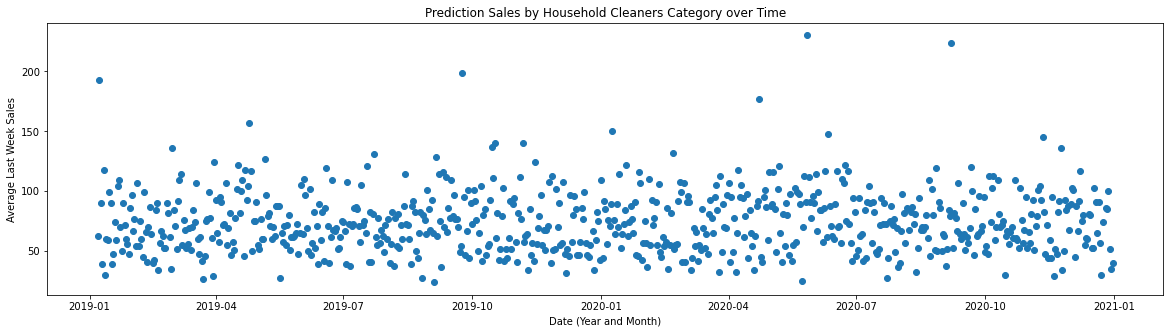

In [36]:
wegmanspred["DATE_KEY"] =  pd.to_datetime(wegmanspred["DATE_KEY"])
x_date = wegmanspred['DATE_KEY'].value_counts().index
y = wegmanspred.loc[wegmanspred.CATEGORY_NAME=='HOUSEHOLD CLEANERS'].groupby(['DATE_KEY']).agg({'Prediction': ['sum']})


plt.figure(figsize=(20, 5))
plt.scatter(x_date,y)

plt.title("Prediction Sales by Household Cleaners Category over Time")

plt.xlabel("Date (Year and Month)")
plt.ylabel("Average Last Week Sales")
plt.show()

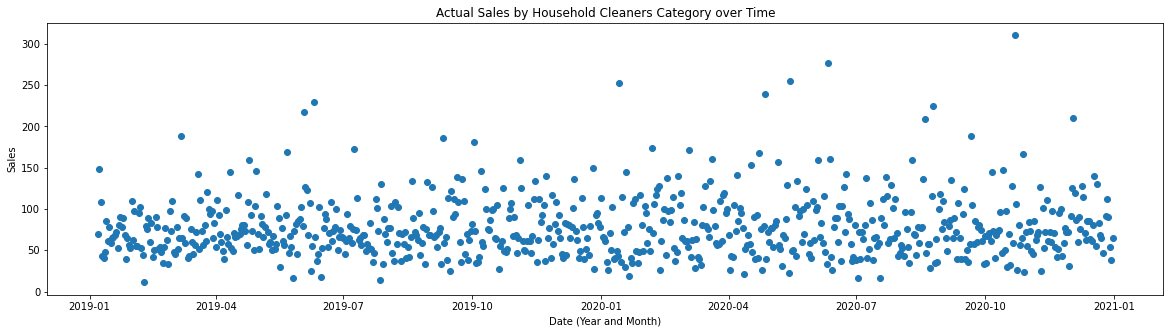

In [35]:
wegmanspred["DATE_KEY"] =  pd.to_datetime(wegmanspred["DATE_KEY"])
x_date = wegmanspred['DATE_KEY'].value_counts().index
y = wegmanspred.loc[wegmanspred.CATEGORY_NAME=='HOUSEHOLD CLEANERS'].groupby(['DATE_KEY']).agg({'SALES': ['mean']})


plt.figure(figsize=(20, 5))
plt.scatter(x_date,y)

plt.title("Actual Sales by Household Cleaners Category over Time")

plt.xlabel("Date (Year and Month)")
plt.ylabel("Sales")
plt.show()